# Import Libraries

In [ ]:
!pip install ndlib

In [3]:
import csv
from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import networkx.algorithms.community as nx_comm
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

In [4]:
import pandas as pd 
import numpy as np
import itertools  
from itertools import chain
import math
import networkx.algorithms.community as nxcom
import collections

In [5]:
!unzip /content/sample_data/checkins.txt.zip

unzip:  cannot find or open /content/sample_data/checkins.txt.zip, /content/sample_data/checkins.txt.zip.zip or /content/sample_data/checkins.txt.zip.ZIP.


# First Run

In [8]:
# Reading the checkins dataset
#check = pd.read_csv("/content/sample_data/checkins.txt", delimiter = "\t", names=["User", "Check-in-time", "Latitude", "Longitude", "Location id"])
check = pd.read_csv("checkins.txt", delimiter = "\t", names=["User", "Check-in-time", "Latitude", "Longitude", "Location id"])
#check['Check-in-time'] = pd.to_datetime(check['Check-in-time']).dt.tz_convert(None)
#check.head()

**Splitting the Check-in-time Data into two columns**
*     Check_In_Date
*     Check_In_Time

**Exatrcting the data for the month of July**


In [9]:
check[['Check_In_Date','Check_In_Time']] = check['Check-in-time'].str.split('T',expand=True)
check = check.drop(columns=['Check-in-time'])

# Exatrcting the data for the month of July
july_check = check[check['Check_In_Date'].str.contains("2010-07")]
july_check

,User,Latitude,Longitude,Location id,Check_In_Date,Check_In_Time
127,0,30.267910,-97.749312,21714,2010-07-31,16:53:09Z
128,0,30.251031,-97.754092,49904,2010-07-31,01:49:44Z
129,0,30.266240,-97.745908,9225,2010-07-29,23:59:07Z
130,0,30.270734,-97.753703,9241,2010-07-29,17:23:56Z
131,0,30.201557,-97.667127,9410,2010-07-26,16:37:17Z
...,...,...,...,...,...,...
1458377,9993,38.582918,-90.490548,146539,2010-07-04,15:42:12Z
1458378,9993,38.593260,-90.497497,130618,2010-07-04,15:27:24Z
1458379,9993,38.593763,-90.555972,407945,2010-07-03,02:12:52Z
1458380,9993,38.593160,-90.557285,123750,2010-07-03,02:04:42Z


***July Check Data CSV***

In [ ]:
# Saving the DataForJuly csv
#july_check.to_csv('DataForJulyCheckins_Original.csv', index=False)

In [ ]:
#Checking for node having max counts in location ID**
#july_check['Location id'].value_counts()

*Selecting any 5 location ID and creating a dataframe called "data_final"*

In [ ]:
# Data for July for 5 location ID's 
#display(july_check)
#data_final = july_check.loc[july_check['Location id'].isin(['19542','9410', '10259', '9241', '304939'])]
data_final = july_check
#display(data_final)
# Removing Z and colon from the Check-in-Time
data_final['Check_In_Time'] = data_final['Check_In_Time'].str.replace('Z','')
data_final['Check_In_Time'] = data_final['Check_In_Time'].str.replace(':','')

# Converting string to integer
data_final['Check_In_Time'] = data_final['Check_In_Time'].astype(str).astype(int)
#data_final.head(200)

**OPTIONAL STEP:** 

*Checking if the locationID has the same Longitude and Latitude*

**Dividing the July dataset in intervals of 4hours:**
* *00:00 - 4:00 --> Group A*
* *4:00 - 8:00 --> Group B*
* *8:00 - 12:00 --> Group C*
* *12:00 - 16:00 --> Group D*
* *16:00 - 20:00 --> Group E*
* *20:00 - 00:00 --> Group F*

In [11]:
# create a list of our conditions
conditions = [
    (data_final["Check_In_Time"] <= 40000),
    (data_final["Check_In_Time"] > 40000) & (data_final["Check_In_Time"] <= 80000),
    (data_final["Check_In_Time"] > 80000) & (data_final["Check_In_Time"] <= 120000),
    (data_final["Check_In_Time"] > 120000) & (data_final["Check_In_Time"] <= 160000),
    (data_final["Check_In_Time"] > 160000) & (data_final["Check_In_Time"] <= 200000),
    (data_final["Check_In_Time"] > 200000) 
    ]

# create a list of the values we want to assign for each condition
values = ['Group_A', 'Group_B', 'Group_C', 'Group_D', 'Group_E', 'Group_F']

# create a new column and use np.select to assign values to it using our lists as arguments
data_final['Time Intervals'] = np.select(conditions, values)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [12]:
# Saving the TimeInterval dataset to csv
#data_final.to_csv('TimeIntervalsForAllLocations_Original.csv', index=False)

*Creating a list of tuples of each User present on the same location at the same date within a time interval*

In [ ]:
# Grouping the data
grouped_df = data_final.groupby(["Check_In_Date", "Time Intervals", "Location id"])

# Initializing the list
final_data = []
tupl = []

# Extracting the grouped UserID's and storing it as list 
for key,item in grouped_df:
    a_group = grouped_df.get_group(key)
    Name_ID = a_group["User"].tolist()

    final_data.append(Name_ID)
#print(final_data)   
# Creating tuples of the users interacting within the same interval 
for element in final_data:
    if len(element) > 1:
      element = list(itertools.combinations(element, 2))
#        else:
#            element = list(itertools.combinations(element, 1))
      tupl.append(element)
        #print(element)
    
tupl = list(chain.from_iterable(tupl))
#print(tupl)


***Creating the CSV file for the pre-processed Data***

In [15]:
# Creating a DataFrame of the Users interacted between the time intervals in the month of July
Nodes_data = pd.DataFrame(tupl, columns = ["User1", "User2"])

# Checking the shape of the dataFrame
print("The shape of the DataFrame is: \n", Nodes_data.shape)

# Saving the DataFrame as csv file
Nodes_data.to_csv('Final_Nodes_Data.csv', index=False)

The shape of the DataFrame is: 
 (10066, 2)


## Creating Tuples Functions

In [16]:
def create_tuple(input_df, locationkey):
  # Grouping the data
  #grouped_df = input_df.loc[input_df['Location id'].isin(locationkey)]
  grouped_df = grouped_df.groupby(["Check_In_Date", "Time Intervals", "Location id"])
  
  # Initializing the list
  final_data = []
  tupl = []

  # Extracting the grouped UserID's and storing it as list 
  for key,item in grouped_df:
    a_group = grouped_df.get_group(key)
    name_ID = a_group["User"].tolist()
    final_data.append(name_ID)
    
    # Creating tuples of the users interacting within the same interval 
  for element in final_data:
      if len(element) > 1:
          element = list(itertools.combinations(element, 2))
#       else:
#           element = list(itertools.combinations(element, 1))
      tupl.append(element)
      #print(element)
    
  tupl = list(chain.from_iterable(tupl))
  # Creating a DataFrame of the Users interacted between the time intervals in the month of July
  nodes_data = pd.DataFrame(tupl, columns = ["User1", "User2"])
  nodes_data = nodes_data.dropna() # Removing the NaN value rows

  # Creating a dataframe called Weight_nodes containing the count of every tupple interaction
  nodes_data = nodes_data.groupby(['User1', 'User2']).size().reset_index(name='count').astype(int)

  # Saving the DataFrame as csv file
  nodes_data.to_csv('Nodes_Data_v1.csv', index=False)
  return nodes_data

## *Simulation Functions*



## *Infection Curve*

In [17]:
def get_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SIRModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('gamma', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    recovered = np.array([iterations[i]['node_count'][2] for i in range(n_iter)])/no_nodes
    return times, infected, recovered

## *SIS Model Scale Free Function*

In [18]:
def get_SIS_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SISModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('lambda', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    return times, infected

## *SIR Infection Curve Function*

In [19]:
def get_SIR_infection_curve(G, infection_rate, recovery_rate, n_iter):
    
    model = ep.SIRModel(G)
    no_nodes = G.number_of_nodes()
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', infection_rate)
    cfg.add_model_parameter('gamma', recovery_rate)
    cfg.add_model_parameter("fraction_infected", 0.05)
    model.set_initial_status(cfg)
    
    times = np.array(range(n_iter))
    
    iterations = model.iteration_bunch(n_iter)
    susceptible = np.array([iterations[i]['node_count'][0] for i in range(n_iter)])/no_nodes
    infected = np.array([iterations[i]['node_count'][1] for i in range(n_iter)])/no_nodes
    recovered = np.array([iterations[i]['node_count'][2] for i in range(n_iter)])/no_nodes
    return times, infected, recovered, susceptible

## *Checkins DataSet (RAW)*


In [20]:
#Nodes_data = pd.read_csv("../input/finoutput/Final_Nodes_Data.csv") #Reading CSV
#Nodes_data = pd.read_csv("Final_Nodes_Data.csv") #Reading CSV
print("\n Shape of the original DataFrame (before removing duplicates) : " , Nodes_data.shape)

# Checking the number of NAN values in the dataframe
Nan_val = Nodes_data['User2'].isna().sum()
print("\n Number of NaN values: " , Nan_val)

Nodes_data = Nodes_data.dropna() # Removing the NaN value rows
print("\n Shape of the dataframe after dropping NaN values:" , Nodes_data.shape)

# Creating a dataframe called Weight_nodes containing the count of every tupple interaction
Weight_nodes = Nodes_data.groupby(['User1', 'User2']).size().reset_index(name='count')
Weight_nodes = Weight_nodes.astype(int)
print("\n Shape of the new Weight_nodes DataFrame: " , Weight_nodes.shape)

#print("\n \n Weight Node" , Weight_nodes.head())


 Shape of the original DataFrame (before removing duplicates) :  (10066, 2)

 Number of NaN values:  0

 Shape of the dataframe after dropping NaN values: (10066, 2)

 Shape of the new Weight_nodes DataFrame:  (5918, 3)


## Graph & Statistics (Colocation)

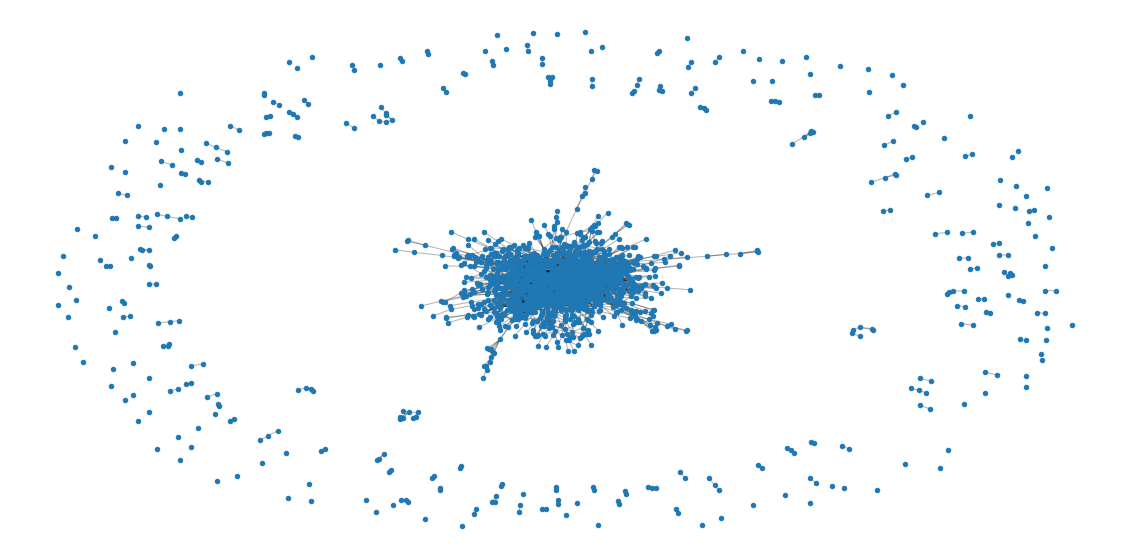

In [21]:
G = nx.from_pandas_edgelist(Weight_nodes,'User1','User2', edge_attr='count')
durations = [i['count'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

a4_dims = (20, 10)
fig, ax = plt.subplots(figsize = a4_dims)
plt.axis('off')
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha = 0.3)
plt.show()

***Graph Statistics***

In this following section we find the: 

*   Number of Nodes
*   Number of Edges
*   Average degree of the graph
*   Maximum degree of the graph
*   Plot the degree distribution








In [22]:
# Finding the Graph statistics
Nodes = G.number_of_nodes()
Edges = G.number_of_edges()
avg_deg = float(Edges) / Nodes
degrees = [val for (node, val) in G.degree()]
print("Number of Nodes in the Colocation Graph: " , Nodes)
print("Number of Edges in the Colocation Graph: ", Edges)
print("Average degree: ", round(avg_deg,2))
print("The maximum degree in the Graph: ", max(degrees))

Number of Nodes in the Colocation Graph:  2068
Number of Edges in the Colocation Graph:  5918
Average degree:  2.86
The maximum degree in the Graph:  83


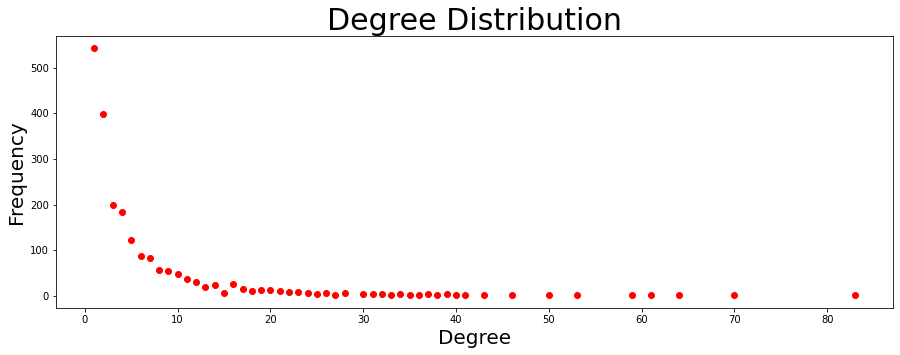

In [37]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

a4_dims = (15, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.scatter(deg, cnt, color="r")

plt.title("Degree Distribution", fontsize=30)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Degree", fontsize=20)
ax.set_xticks(np.arange(0, 85, 10))
#ax.set_xticks([d + 10 for d in deg])
#ax.set_xticklabels(deg)


## ***Simulations***


 ***Infection Curve*** 

100%|██████████| 500/500 [00:02<00:00, 199.21it/s]


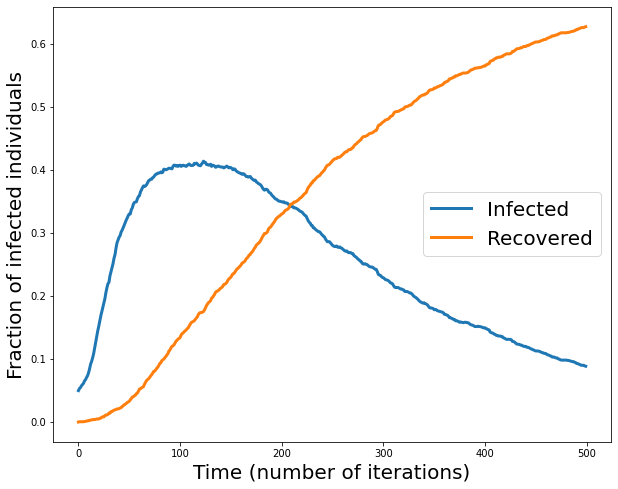

In [24]:
# Infection Curve for Graph(G)
curve = get_infection_curve(G, 0.01,0.005, 500)

a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

ax.plot(curve[0],curve[1], label = 'Infected', linewidth = 3)
ax.plot(curve[0],curve[2], label = 'Recovered', linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)

***Reducing transmission rate***


*explore the effect of reducing the transmission rate between individuals.*

100%|██████████| 500/500 [00:01<00:00, 250.86it/s]


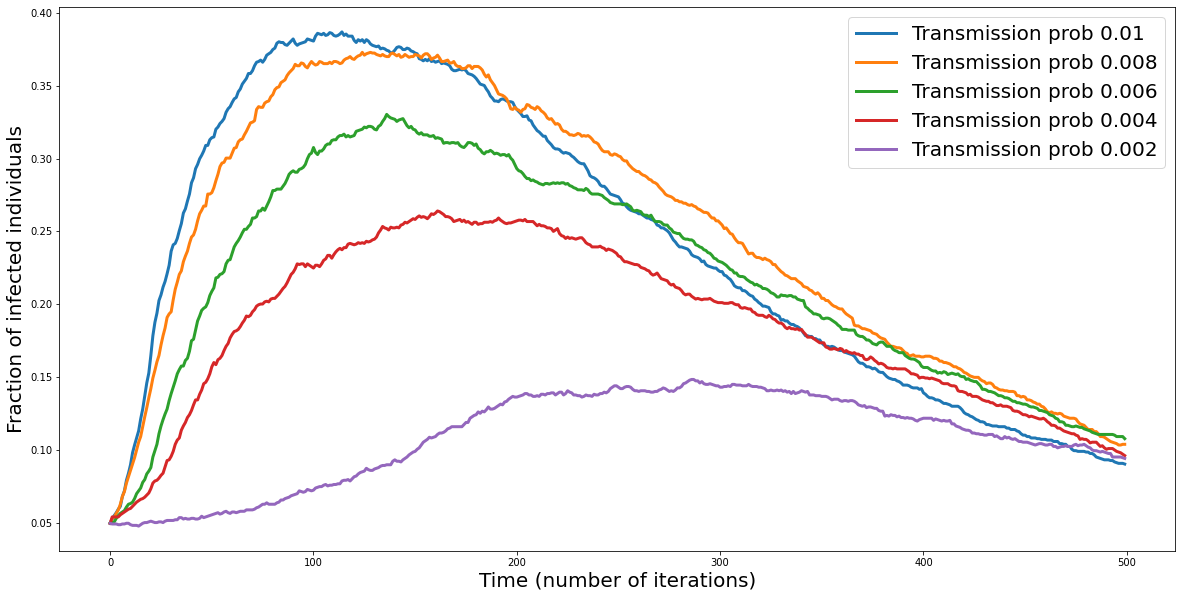

In [25]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

betas = [0.01, 0.008, 0.006, 0.004, 0.002]

for i in range(5):
    curve = get_infection_curve(G, betas[i],0.005, 500)
    ax.plot(curve[0],curve[1], label = 'Transmission prob '+str(betas[i]), linewidth = 3)

plt.legend(loc = 'upper right', fontsize=20)
plt.show()

*Fraction of infected individuals (Hospital Bed Capacity Curve)*

100%|██████████| 500/500 [00:01<00:00, 263.11it/s]


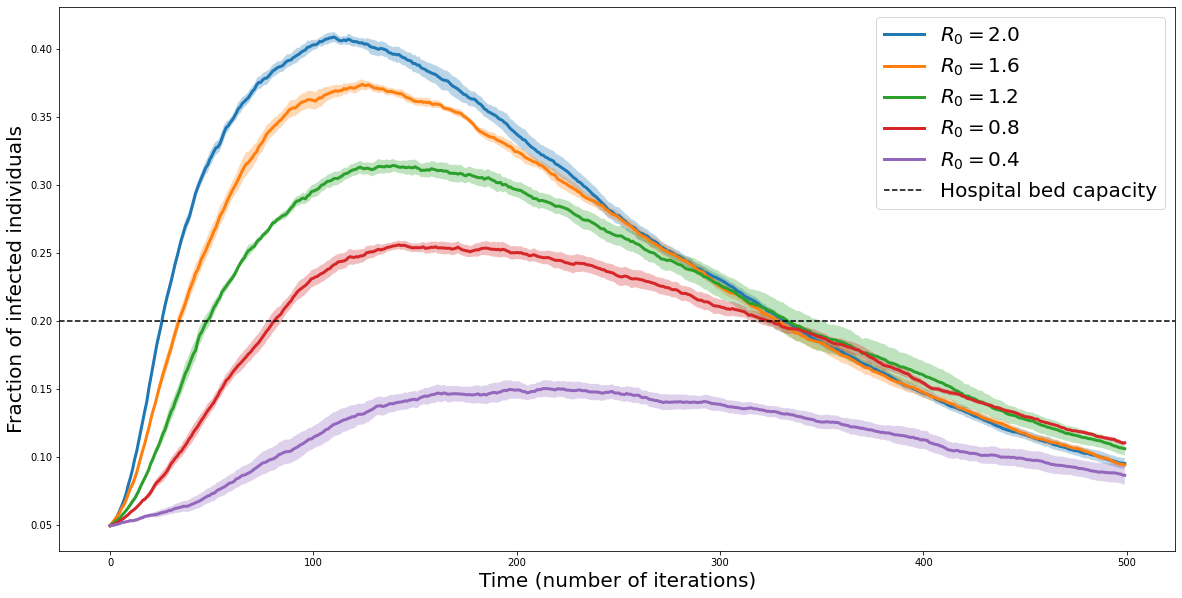

In [ ]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

betas = [0.01, 0.008, 0.006, 0.004, 0.002]
no_experiments = 5

for i in range(5):
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_infection_curve(G, betas[i],0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = '$R_0=$'+str(betas[i]/0.005), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)

plt.axhline(y=0.2,label='Hospital bed capacity',color='black',linestyle='--')
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

*SIS Model Scale Free Graph*

100%|██████████| 1000/1000 [00:08<00:00, 116.66it/s]


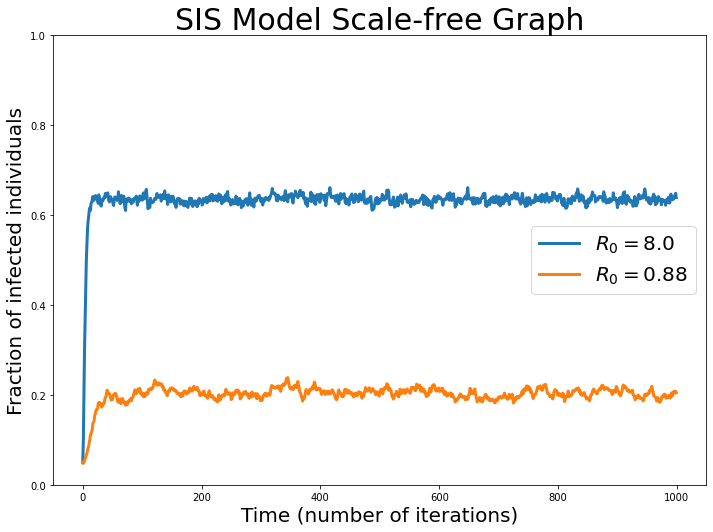

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)


plt.title("SIS Model Scale-free Graph", fontsize = 30)
plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylim(0,1)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

R0 = 2.0
curve1 = get_SIS_infection_curve(G, 0.1*R0, 0.1, 1000)
ax.plot(curve1[0],curve1[1], label = '$R_0 = $'+str(R0*4), linewidth = 3)

R0 = 0.22
curve2 = get_SIS_infection_curve(G, 0.1*R0, 0.1, 1000)
ax.plot(curve2[0],curve2[1], label = '$R_0 = $'+str(R0*4), linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)
plt.show()

*SIR Model*

100%|██████████| 800/800 [00:03<00:00, 250.96it/s]


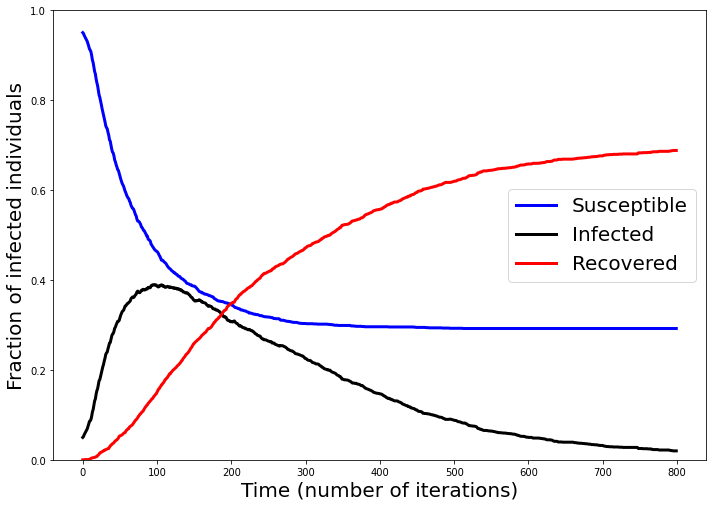

In [ ]:
curve = get_SIR_infection_curve(G, 0.01,0.005, 800)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.ylim(0,1)
plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

ax.plot(curve[0],curve[3], label = 'Susceptible', color='blue', linewidth = 3)
ax.plot(curve[0],curve[1], label = 'Infected', color = 'black', linewidth = 3)
ax.plot(curve[0],curve[2], label = 'Recovered', color = 'red', linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)

## *Betweeness Centrality & Node Removal on Raw data*

In [ ]:
bet_centrality = nx.betweenness_centrality(G, normalized = True, 
                                              endpoints = False)
bet_centrality = dict(sorted(bet_centrality.items(), key=lambda item: item[1]))
keys = np.fromiter(bet_centrality.keys(), dtype=float)

*Node Removal Fraction of infected individuals curve*

100%|██████████| 500/500 [00:01<00:00, 259.05it/s]


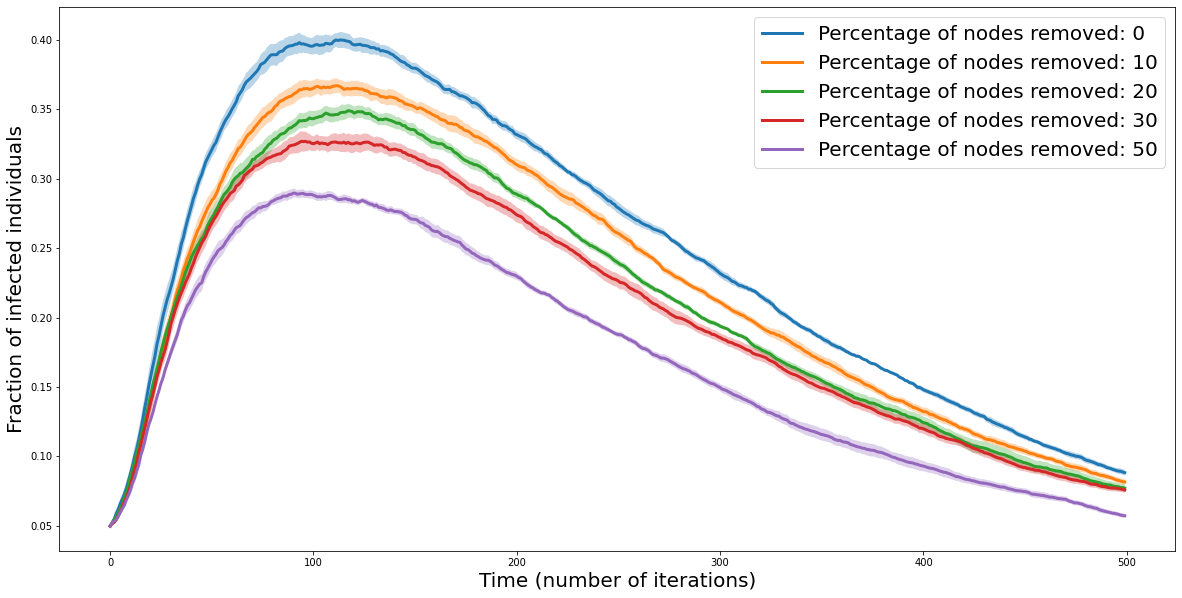

In [ ]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

perc = [0,10,20,30,50]
no_experiments = 5

ranks = keys

for i in range(5):
    H = G.copy()
    number = round(float(perc[i])*G.number_of_nodes()/100)
    top_nodes = ranks[:number]
    for n in top_nodes:
        H.remove_edges_from([(n,out) for out in G.neighbors(n)])
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_SIR_infection_curve(H, 0.01,0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = 'Percentage of nodes removed: '+str(perc[i]), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

## *EigenVector Centrality & Node Removal on Raw data*

In [ ]:
eig_centrality = nx.eigenvector_centrality(G)

keys_ei = np.fromiter(eig_centrality.keys(), dtype=float)
print(keys_ei)
print("Dict: " , eig_centrality.keys())

*Node Removal Fraction of infected individuals curve*

100%|██████████| 500/500 [00:01<00:00, 337.54it/s]


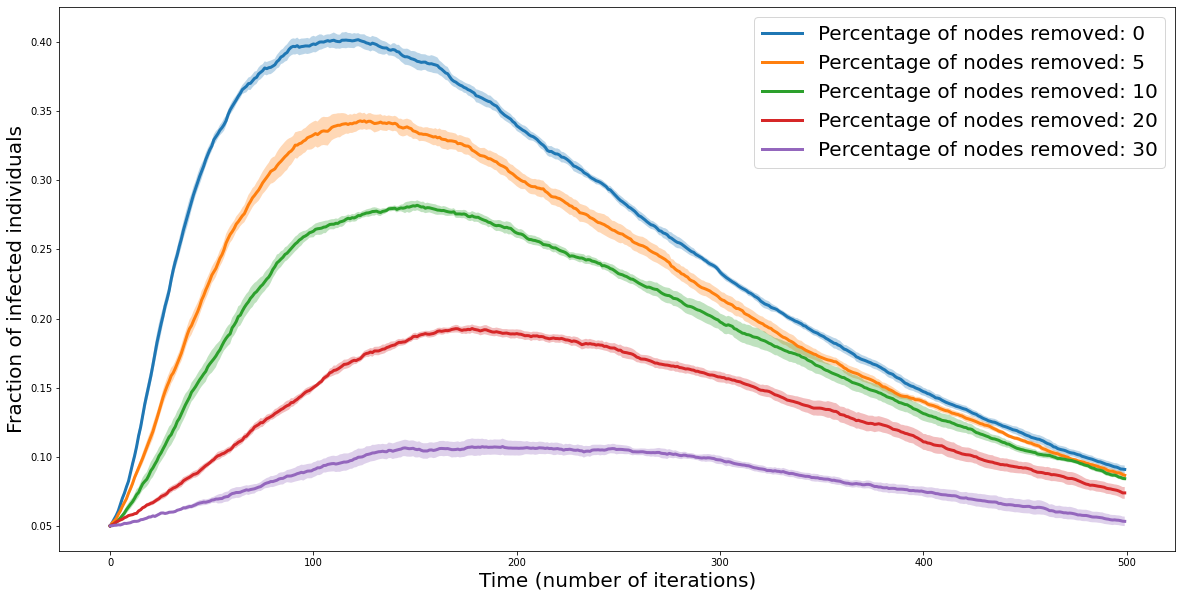

In [ ]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

perc = [0, 5, 10,20,30]
no_experiments = 5

ranks = keys_ei

for i in range(5):
    H = G.copy()
    number = round(float(perc[i])*G.number_of_nodes()/100)
    top_nodes = ranks[:number]
    for n in top_nodes:
        H.remove_edges_from([(n,out) for out in G.neighbors(n)])
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_SIR_infection_curve(H, 0.01,0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = 'Percentage of nodes removed: '+str(perc[i]), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

# Second Run - Community Detetection(Friendship DataSet)

## *Data PreProcessing*

This module focuses on data pre-processing for community dataset.


*   Finding Communities
*   Extracting Users with highest degree in each community
*   Removing those highest degree users 
*   Saving the final dataset as "bipasha" 







In [6]:
# Load the friendship datset 
#friend_df = pd.read_csv("/content/sample_data/friendship-network.csv")
friend_df = pd.read_csv("/content/sample_data/friendship-network.csv")
#friend_df.head()

In [7]:
# Creating the community Graph(g_fr)
g_fr = nx.from_pandas_edgelist(friend_df, source='Source', target='Target') 

# Creating communities
communities = sorted(nxcom.greedy_modularity_communities(g_fr), key=len, reverse=True)
communities = [list(x) for x in communities]

In [31]:
# Time Interval Dataset for 5 locations
com_df = pd.read_csv("/content/sample_data/TimeIntervalsForAllLocations_Original.csv")

In [32]:
def create_tuple(input_df):
  # Grouping the data
  #grouped_df = input_df.loc[input_df['Location id'].isin(locationkey)]
  grouped_df = input_df.groupby(["Check_In_Date", "Time Intervals", "Location id"])
  
  # Initializing the list
  final_data = []
  tupl = []

  # Extracting the grouped UserID's and storing it as list 
  for key,item in grouped_df:
      a_group = grouped_df.get_group(key)
      name_ID = a_group["User"].tolist()
      final_data.append(name_ID)
    
    # Creating tuples of the users interacting within the same interval 
  for element in final_data:
      if len(element) > 1:
        element = list(itertools.combinations(element, 2))
#       else:
#           element = list(itertools.combinations(element, 1))
        tupl.append(element)
        #print(element)
    
  tupl = list(chain.from_iterable(tupl))[1:]
  # Creating a DataFrame of the Users interacted between the time intervals in the month of July
  nodes_data = pd.DataFrame(tupl, columns = ["User1", "User2"])
  nodes_data = nodes_data.dropna() # Removing the NaN value rows

  # Creating a dataframe called Weight_nodes containing the count of every tupple interaction
  nodes_data = nodes_data.groupby(['User1', 'User2']).size().reset_index(name='count').astype(int)

  # Saving the DataFrame as csv file
  #nodes_data.to_csv('Nodes_Data_v1.csv', index=False)
  #return tupl
  return nodes_data

In [33]:
# Extracting Users in every communities with highest degree
def node_removal(perc, degree ,communities):
  cat = {}
  house = {}
  com_id = 1

  for i in communities:
    rm_node = math.ceil(perc * len(i))

    for element in i:
        dog = degree.loc[degree['User'] == element]
        #print(dog)
        cat[degree.loc[degree['User'] == element]["User"].values[0]] = degree.loc[degree['User'] == element]["Degree"].values[0]
        #cat[dog["Degree"].values[0]]
    #print(cat)
    
    #house[com_id] = max(list(cat))
    house[com_id] = list({r: cat[r] for r in sorted(cat, key=cat.get('Degree'), reverse=True)}.keys())[:rm_node]
    com_id+=1
    cat = {}

  rm_node1 = []

  for anitem in house:
    for elem in house[anitem]:
      rm_node1.append(elem)
    #for elem in anitem:
      
    
  #print(len(house.values()))
  #print(house.values())
 # house_list=list(house.values())
  #print(len(rm_node1))
  return rm_node1

In [34]:
# Removing the highest degree users from each community 
# Store the dataframe after removing the users to "bipasha"
degree = pd.DataFrame(nx.degree(g_fr), columns = ["User", "Degree"])
hous_list = node_removal(0.2, degree, communities)
bipasha = com_df[~com_df['User'].isin(hous_list)]
print(bipasha.shape)
# Creating the tupples by running the tuples function 
location_simm = create_tuple(bipasha)
#print(location_simm)
#bipasha = com_df[~com_df['User'].isin(rm_node1)]
# Saving the dataset to Final_Friendship.csv
bipasha.to_csv('Final_Friendship.csv', index=False)
#bipasha

(147590, 7)


## Simmiluation 

## Graph & Statistics (Community)

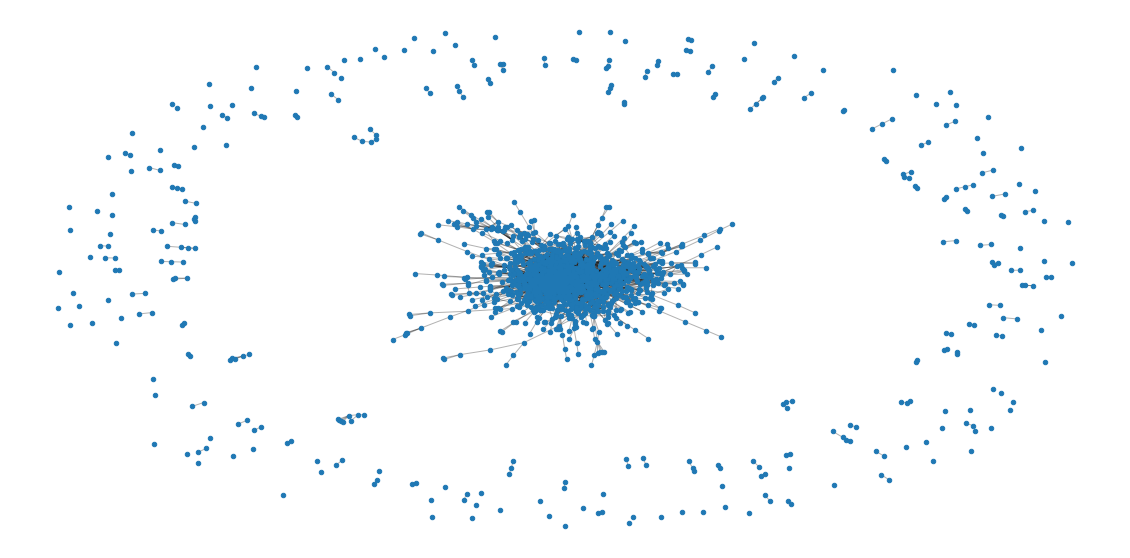

In [38]:
G_com = nx.from_pandas_edgelist(location_simm,'User1','User2', edge_attr='count')
durations = [i['count'] for i in dict(G_com.edges).values()]
labels = [i for i in dict(G_com.nodes).keys()]
labels = {i:i for i in dict(G_com.nodes).keys()}

a4_dims = (20, 10)
fig, ax = plt.subplots(figsize = a4_dims)
plt.axis('off')
pos = nx.spring_layout(G_com)
nx.draw_networkx_nodes(G_com, pos, node_size=20)
nx.draw_networkx_edges(G_com, pos, alpha = 0.3)
plt.show()

***Graph Statistics***

In this following section we find the: 

*   Number of Nodes
*   Number of Edges
*   Average degree of the graph
*   Maximum degree of the graph
*   Plot the degree distribution

In [9]:
#Graph Statistics
Nodes_com = g_fr.number_of_nodes()
Edges_com = g_fr.number_of_edges()
avg_deg_com = float(Edges_com) / Nodes_com
degrees_com = [val for (node, val) in g_fr.degree()]
print("Number of Nodes in the Community Graph: " , Nodes_com)
print("Number of Edges in the Community Graph: ", Edges_com)
print("Average degree: ", round(avg_deg_com,2))
print("The maximum degree in the Graph: ", max(degrees_com))

Number of Nodes in the Community Graph:  10001
Number of Edges in the Community Graph:  140869
Average degree:  14.09
The maximum degree in the Graph:  2405


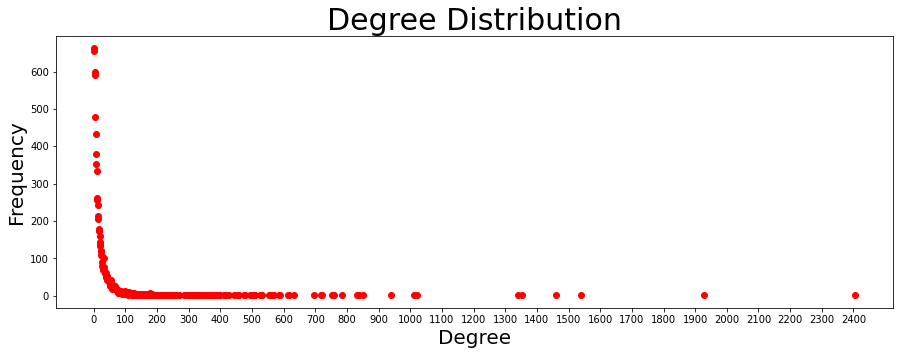

In [11]:
degree_sequence_com = sorted([d for n, d in g_fr.degree()], reverse=True)  # degree sequence
degreeCount_com = collections.Counter(degree_sequence_com)
deg, cnt = zip(*degreeCount_com.items())

a4_dims = (15, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.scatter(deg, cnt, color="r")

plt.title("Degree Distribution", fontsize=30)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Degree", fontsize=20)
ax.set_xticks(np.arange(0, 2500, 100))



*Infection Curve*

100%|██████████| 500/500 [00:01<00:00, 250.98it/s]


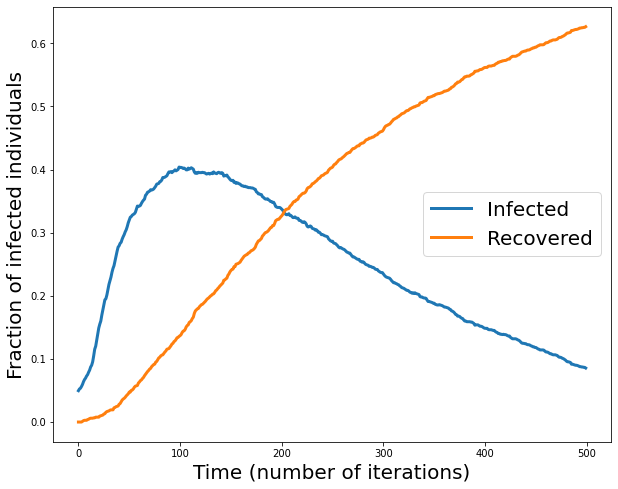

In [ ]:
curve = get_infection_curve(G_com, 0.01,0.005, 500)

a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

ax.plot(curve[0],curve[1], label = 'Infected', linewidth = 3)
ax.plot(curve[0],curve[2], label = 'Recovered', linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)

*Reducing transmissionn rate curve*

100%|██████████| 500/500 [00:01<00:00, 293.10it/s]


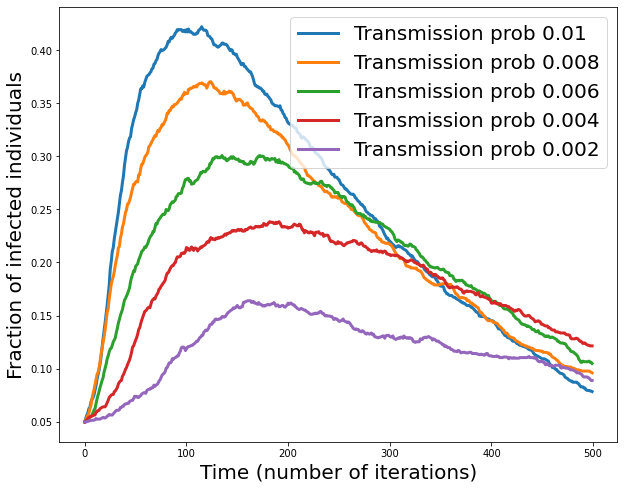

In [ ]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

betas = [0.01, 0.008, 0.006, 0.004, 0.002]

for i in range(5):
    curve = get_infection_curve(G_com, betas[i],0.005, 500)
    ax.plot(curve[0],curve[1], label = 'Transmission prob '+str(betas[i]), linewidth = 3)

plt.legend(loc = 'upper right', fontsize=20)
plt.show()

*Fraction of infected indivisuals (Hospital Bed Capacity Curve)*

100%|██████████| 500/500 [00:01<00:00, 311.55it/s]


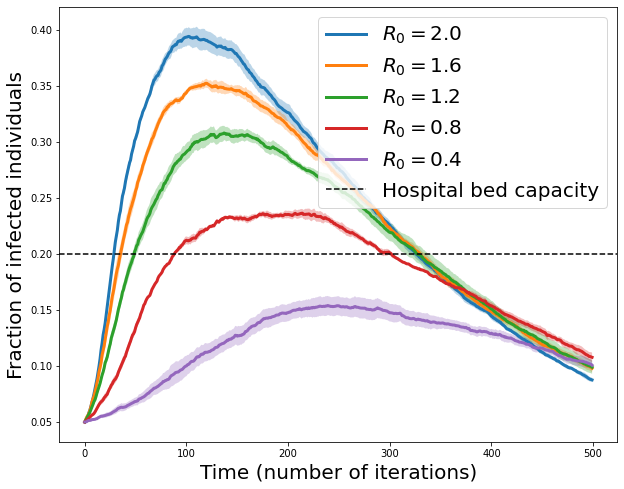

In [ ]:
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

betas = [0.01, 0.008, 0.006, 0.004, 0.002]
no_experiments = 5

for i in range(5):
    experiments = np.zeros((no_experiments,500),dtype=float)
    for ex in range(no_experiments):
        curve = get_infection_curve(G_com, betas[i],0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = '$R_0=$'+str(betas[i]/0.005), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)

plt.axhline(y=0.2,label='Hospital bed capacity',color='black',linestyle='--')
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

*SIS Model Scale Free Graph*

100%|██████████| 500/500 [00:03<00:00, 130.30it/s]


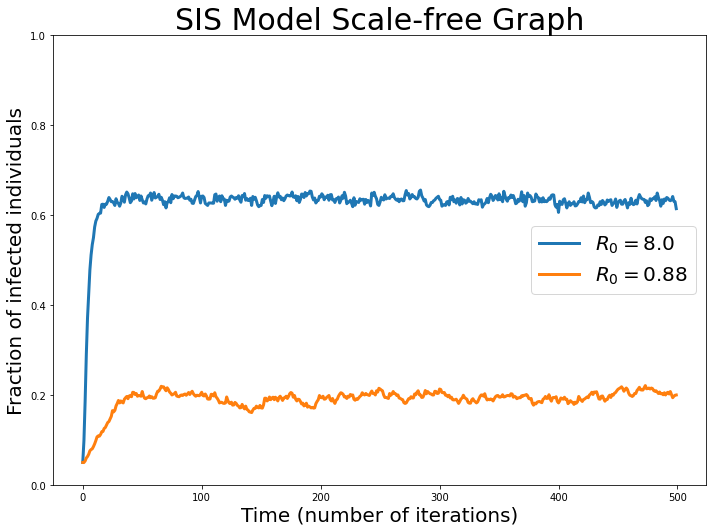

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)


plt.title("SIS Model Scale-free Graph", fontsize = 30)
plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylim(0,1)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

R0 = 2.0
curve1 = get_SIS_infection_curve(G_com, 0.1*R0, 0.1, 500)
ax.plot(curve1[0],curve1[1], label = '$R_0 = $'+str(R0*4), linewidth = 3)

R0 = 0.22
curve2 = get_SIS_infection_curve(G_com, 0.1*R0, 0.1, 500)
ax.plot(curve2[0],curve2[1], label = '$R_0 = $'+str(R0*4), linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)
plt.show()

*SIR Model*

100%|██████████| 800/800 [00:02<00:00, 293.11it/s]


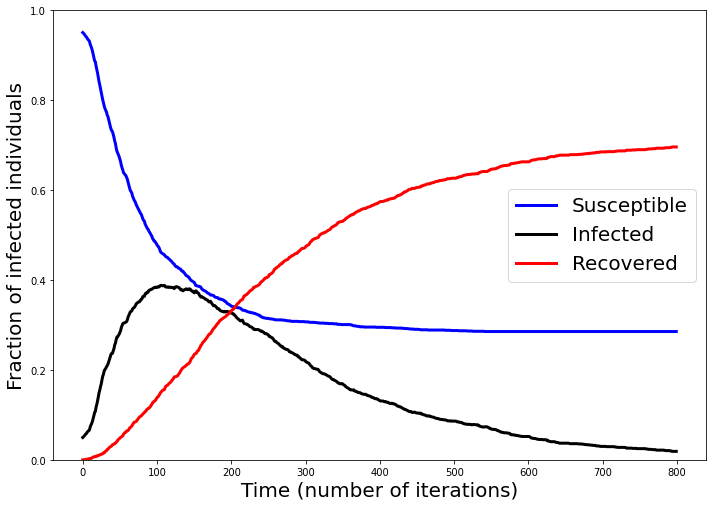

In [ ]:
curve = get_SIR_infection_curve(G_com, 0.01,0.005, 800)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.ylim(0,1)
plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

ax.plot(curve[0],curve[3], label = 'Susceptible', color='blue', linewidth = 3)
ax.plot(curve[0],curve[1], label = 'Infected', color = 'black', linewidth = 3)
ax.plot(curve[0],curve[2], label = 'Recovered', color = 'red', linewidth = 3)

plt.legend(loc = 'center right', fontsize=20)


## Node removal (after removinng the users with high degree)

In [ ]:
# Extracting Users in every communities with highest degree

degree = pd.DataFrame(nx.degree(g_fr), columns = ["User", "Degree"])

def node_removal(perc, degree ,communities):
  cat = {}
  house = {}
  com_id = 1

  for i in communities:
    rm_node = math.ceil(perc * len(i))

    for element in i:
        #dog = degree.loc[degree['User'] == element]
        #print(dog)
        cat[degree.loc[degree['User'] == element]["User"].values[0]] = degree.loc[degree['User'] == element]["Degree"].values[0]
        #cat[dog["Degree"].values[0]]
    #print(cat)
    
    #house[com_id] = max(list(cat))
    house[com_id] = list({r: cat[r] for r in sorted(cat, key=cat.get('Degree'), reverse=False)}.keys())[:rm_node]
    com_id+=1
    cat = {}

  rm_node1 = []

  for anitem in house:
    for elem in house[anitem]:
      rm_node1.append(elem)
    #for elem in anitem:
      
    
  #print(len(house.values()))
  #print(house.values())
  house_list=list(house.values())
  #print(len(rm_node1))
  return rm_node1
  

100%|██████████| 500/500 [00:00<00:00, 1901.09it/s]


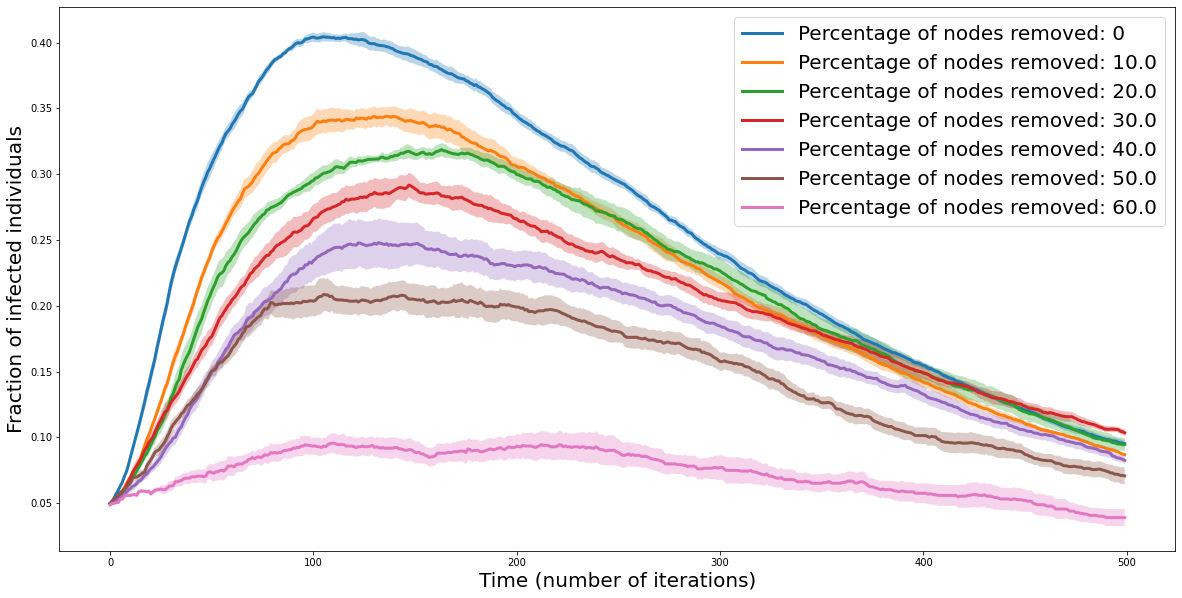

In [ ]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

perc = [0, 0.1, 0.2, 0.3, 0.4,0.5,0.6]
no_experiments = 5

#ranks = np.argsort([-1*G.degree(n) for n in G.nodes()])

for j in perc:
   # H = G.copy()
    #number = round(float(perc[i])*G.number_of_nodes()/100)
    #top_nodes = ranks[:number]
    house_list = node_removal(j, degree, communities)
    bipasha = com_df[~com_df['User'].isin(house_list)]

      # Creating the tuples for the following communities
    #loca_list = ['19542','9410', '10259', '9241', '304939']

    # Creating the tupples by running the tuples function 
    location_simm = create_tuple(bipasha)

    G = nx.from_pandas_edgelist(location_simm,'User1','User2', edge_attr='count')
  #for n in top_nodes:
      #H.remove_edges_from([(n,out) for out in G.neighbors(n)])
    experiments = np.zeros((no_experiments,500),dtype=float)

    for ex in range(no_experiments):
        curve = get_infection_curve(G, 0.01,0.005, 500)
        experiments[ex]=curve[1]
    avg = np.mean(experiments,axis=0)
    std = np.std(experiments,axis=0)
    ax.plot(curve[0],avg, label = 'Percentage of nodes removed: '+str(j*100), linewidth = 3)
    ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()

# Third Run - Location Hotspot Detection

## Pre-Processing

In [42]:
data_final = pd.read_csv("/content/sample_data/TimeIntervalsForAllLocations_Original.csv")

In [43]:
# Grouping the data
grouped_df_E = data_final.groupby(["Check_In_Date", "Time Intervals", "Location id", "User"])
grouped_df_E = pd.DataFrame(grouped_df_E.size().reset_index(name = "Group_Count"))
display(grouped_df_E)

# Initializing the list
final_data_ = []
tupl_lo = []

# Extracting the grouped UserID's and storing it as list 
records = grouped_df_E[["Location id", "User"]].to_records(index=False)
#print(records)
result = list(records)
#print(result)



,Check_In_Date,Time Intervals,Location id,User,Group_Count
0,2010-07-01,Group_A,9066,533,1
1,2010-07-01,Group_A,9117,125,1
2,2010-07-01,Group_A,9117,3229,1
3,2010-07-01,Group_A,9260,131,1
4,2010-07-01,Group_A,9337,3053,1
...,...,...,...,...,...
156645,2010-07-31,Group_F,1537795,6387,1
156646,2010-07-31,Group_F,1537837,6387,1
156647,2010-07-31,Group_F,1537865,534,1
156648,2010-07-31,Group_F,1537871,534,1


In [44]:
df_lo = pd.DataFrame(data_final, columns = ["User", "Location id"])
df_lo['Location id'] =  df_lo['Location id'].astype(str) + 'L'
df_lo = df_lo.groupby(["Location id", "User"]).size().reset_index(name='count')
#df_lo.to_csv('LocationDataSet.csv', index=False)
#Weight_nodes = Weight_nodes.astype(int)

## *Plotting the Graph: Directed & Statistics* 

In [45]:
# store pairs to a list of tuples
G_dir = nx.from_pandas_edgelist(df_lo, 'User', 'Location id', create_using=nx.DiGraph())

# set up a graph and show it
#G = nx.DiGraph()
#G.add_edges_from(tuples)
#nx.draw_networkx(G_dir)
#plt.xticks([], [])
#plt.yticks([], [])
#plt.show()

In [ ]:
a4_dims = (20, 15)
fig, ax = plt.subplots(figsize = a4_dims)
plt.axis('off')
pos = nx.spring_layout(G_dir)
nx.draw_networkx_nodes(G_dir, pos, node_size=20)
nx.draw_networkx_edges(G_dir, pos, alpha = 0.3)
plt.show()

***Graph Statistics***

In this following section we find the: 

*   Number of Nodes
*   Number of Edges
*   Average degree of the graph
*   Maximum degree of the graph
*   Plot the degree distribution

In [47]:
Nodes_dir = G_dir.number_of_nodes()
Edges_dir = G_dir.number_of_edges()
avg_deg_dir = float(Edges_dir) / Nodes_dir
degrees_dir = [val for (node, val) in G_dir.in_degree()]
print("Number of Nodes in the Hotspot Graph: " , Nodes_dir)
print("Number of Edges in the Hotspot Graph: ", Edges_dir)
print("Average degree: ", round(avg_deg_dir,2))
print("The maximum Indegree in the Graph: ", max(degrees_dir))

Number of Nodes in the Hotspot Graph:  98135
Number of Edges in the Hotspot Graph:  122621
Average degree:  1.25
The maximum Indegree in the Graph:  185


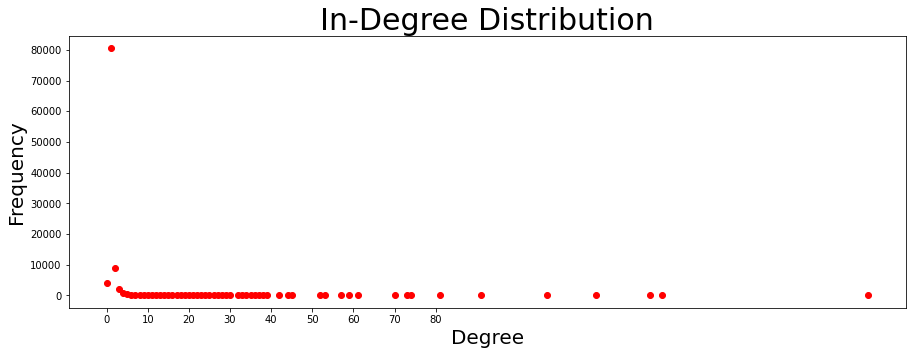

In [48]:
degree_sequence_dir = sorted([d for n, d in G_dir.in_degree()], reverse=True)  # degree sequence
degreeCount_dir = collections.Counter(degree_sequence_dir)
deg, cnt = zip(*degreeCount_dir.items())

a4_dims = (15, 5)
fig, ax = plt.subplots(figsize=a4_dims)
plt.scatter(deg, cnt, color="r")

plt.title("In-Degree Distribution", fontsize=30)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Degree", fontsize=20)
ax.set_xticks(np.arange(0, 85, 10))


## Node removal (after removinng the users with high Indegree)

In [ ]:
# Indegree Calculation 
in_deg_centrality = nx.in_degree_centrality(G_dir)
in_deg_centrality = dict(sorted(in_deg_centrality.items(), key=lambda item: item[1], reverse=True))
in_deg_centrality = {key:val for key, val in in_deg_centrality.items() if val != 0}
keys_in = np.array(list(in_deg_centrality.keys()))
length = len(keys_in)
print(keys_in)

'''perc = [0.1, 0.2]

for i in perc:
  listloc=[]

  keys_in = keys_in[math.ceil(length * i):]
  #print("Keys:", keys_in)
  for key in keys_in:
    key = key[:-1]
    listloc.append(key)
  print(listloc)

  # Creating tuples for hotspot 
  hotspotuple = create_tuple(data_final, listloc)
  display(hotspotuple)
'''

['19542L' '9410L' '10259L' ... '999947L' '999954L' '999997L']


'perc = [0.1, 0.2]\n\nfor i in perc:\n  listloc=[]\n\n  keys_in = keys_in[math.ceil(length * i):]\n  #print("Keys:", keys_in)\n  for key in keys_in:\n    key = key[:-1]\n    listloc.append(key)\n  print(listloc)\n\n  # Creating tuples for hotspot \n  hotspotuple = create_tuple(data_final, listloc)\n  display(hotspotuple)\n'

In [ ]:
def create_tuple(input_df,locationkey):
  # Grouping the data
  grouped_df = input_df.loc[input_df['Location id'].isin(locationkey)]
  grouped_df = grouped_df.groupby(["Check_In_Date", "Time Intervals", "Location id"])
  
  # Initializing the list
  final_data = []
  tupl = []

  # Extracting the grouped UserID's and storing it as list 
  for key,item in grouped_df:
      a_group = grouped_df.get_group(key)
      name_ID = a_group["User"].tolist()
      final_data.append(name_ID)
    
    # Creating tuples of the users interacting within the same interval 
  for element in final_data:
      if len(element) > 1:
        element = list(itertools.combinations(element, 2))
#       else:
#           element = list(itertools.combinations(element, 1))
        tupl.append(element)
        #print(element)
    
  tupl = list(chain.from_iterable(tupl))
  # Creating a DataFrame of the Users interacted between the time intervals in the month of July
  nodes_data = pd.DataFrame(tupl, columns = ["User1", "User2"])
  nodes_data = nodes_data.dropna() # Removing the NaN value rows

  # Creating a dataframe called Weight_nodes containing the count of every tupple interaction
  nodes_data = nodes_data.groupby(['User1', 'User2']).size().reset_index(name='count').astype(int)

  # Saving the DataFrame as csv file
  #nodes_data.to_csv('Nodes_Data_v1.csv', index=False)
  #return tupl
  return nodes_data

  5%|▌         | 26/500 [00:00<00:01, 256.48it/s]

(5918, 3)


  9%|▉         | 45/500 [00:00<00:01, 446.73it/s]

(2090, 3)


 10%|▉         | 48/500 [00:00<00:00, 474.17it/s]

(1905, 3)


 11%|█         | 55/500 [00:00<00:00, 541.82it/s]

(1417, 3)


 19%|█▊        | 93/500 [00:00<00:00, 924.13it/s]

(607, 3)


 33%|███▎      | 163/500 [00:00<00:00, 1623.51it/s]

(390, 3)


  0%|          | 0/500 [00:00<?, ?it/s]

(170, 3)


100%|██████████| 500/500 [00:00<00:00, 4482.67it/s]


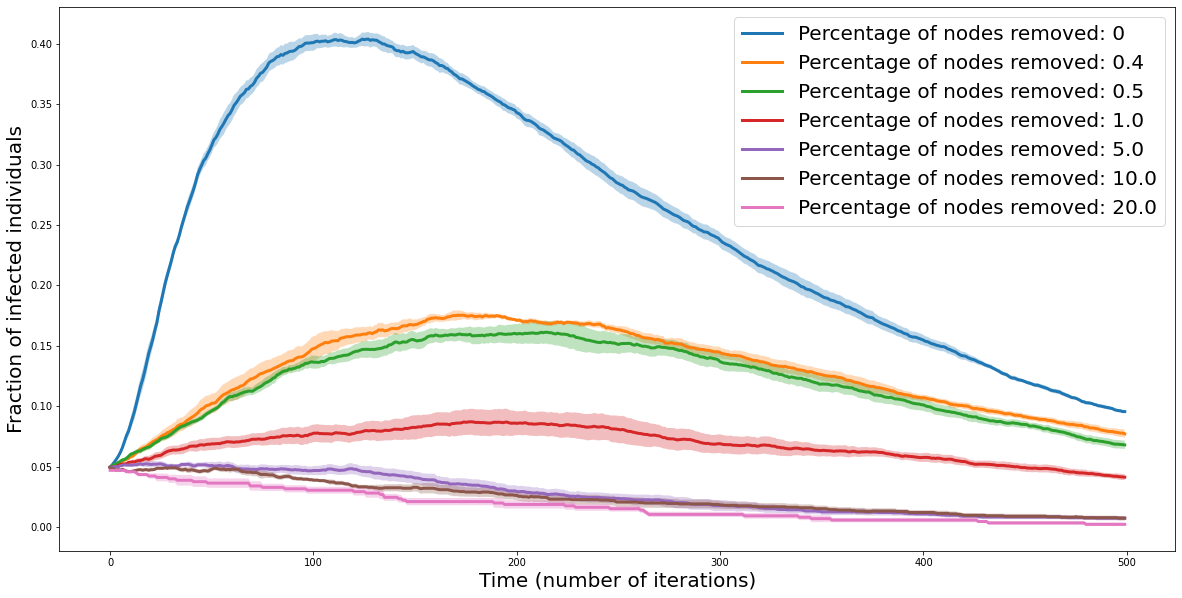

In [ ]:
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)

plt.xlabel("Time (number of iterations)", fontsize = 20)
plt.ylabel("Fraction of infected individuals", fontsize = 20)

perc = [0,0.004, 0.005, 0.01,0.05,0.1,0.2]
no_experiments = 5

#ranks = np.argsort([-1*G.degree(n) for n in G.nodes()])

for i in perc:
  listloc=[]
  
  keys_in_mod = keys_in[math.ceil(length * i):]
  
  for key in keys_in_mod:
    key = key[:-1]
    listloc.append(key)
#  print(listloc[0])

  # Creating tuples for hotspot 
  hotspotuple = create_tuple(data_final, listloc)
  print(hotspotuple.shape)

  G = nx.from_pandas_edgelist(hotspotuple, 'User1', 'User2', edge_attr='count')

  experiments = np.zeros((no_experiments,500),dtype=float)
  for ex in range(no_experiments):
    curve = get_infection_curve(G, 0.01,0.005, 500)
    experiments[ex]=curve[1]
  avg = np.mean(experiments,axis=0)
  std = np.std(experiments,axis=0)
  ax.plot(curve[0],avg, label = 'Percentage of nodes removed: '+str(i*100), linewidth = 3)
  ax.fill_between(curve[0],avg-0.5*std, avg + 0.5*std, alpha = 0.3)
    
plt.legend(loc = 'upper right', fontsize=20)
plt.show()